Experiment with adding noise originating from a IBMQ machine to the pennylane's builtin QNG optimizer and to a simple manual method of computing the Fisher information metric tensor.

More info on the algorithm:
https://pennylane.ai/qml/demos/tutorial_quantum_natural_gradient.html

More info on the noise model:
https://qiskit.org/documentation/stubs/qiskit.providers.aer.noise.NoiseModel.html#qiskit.providers.aer.noise.NoiseModel
https://qiskit.org/documentation/stubs/qiskit.providers.aer.QasmSimulator.html#qiskit.providers.aer.QasmSimulator

In [16]:
import numpy as np
import qiskit
import pennylane as qml
from pennylane import expval, var

qiskit.IBMQ.load_account()

# Build noise model from backend properties
provider = qiskit.IBMQ.get_provider(group='open')
ibmq_backend = provider.get_backend('ibmq_burlington')
device_properties = ibmq_backend.properties()
noise_model = qiskit.providers.aer.noise.NoiseModel.from_backend(device_properties)

# Get coupling map from backend
coupling_map = ibmq_backend.configuration().coupling_map

# Get basis gates from noise model
basis_gates = noise_model.basis_gates

# Provision the the default
dev = qml.device('qiskit.aer', wires=3, noise_model=noise_model, 
                 basis_gates=basis_gates, coupling_map=coupling_map, backend='qasm_simulator')


@qml.qnode(dev)
def circuit(params):
    # |psi_0>: state preparation
    qml.RY(np.pi / 4, wires=0)
    qml.RY(np.pi / 3, wires=1)
    qml.RY(np.pi / 7, wires=2)

    # V0(theta0, theta1): Parametrized layer 0
    qml.RZ(params[0], wires=0) 
    qml.RZ(params[1], wires=1)

    # W1: non-parametrized gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])

    # V_1(theta2, theta3): Parametrized layer 1
    qml.RY(params[2], wires=1)
    qml.RX(params[3], wires=2)

    # W2: non-parametrized gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])

    return qml.expval(qml.PauliY(0))


params = np.array([0.432, -0.123, 0.543, 0.233])

ibmqfactory.load_account:WARNING:2020-04-17 08:52:54,084: Credentials are already in use. The existing account in the session will be replaced.


In [17]:
g0 = np.zeros([2, 2])


def layer0_subcircuit(params):
    """This function contains all gates that
    precede parametrized layer 0"""
    qml.RY(np.pi / 4, wires=0)
    qml.RY(np.pi / 3, wires=1)
    qml.RY(np.pi / 7, wires=2)

@qml.qnode(dev)
def layer0_diag(params):
    layer0_subcircuit(params)
    return var(qml.PauliZ(0)), var(qml.PauliZ(1))


# calculate the diagonal terms
varK0, varK1 = layer0_diag(params)
g0[0, 0] = varK0 / 4
g0[1, 1] = varK1 / 4

@qml.qnode(dev)
def layer0_off_diag_single(params):
    layer0_subcircuit(params)
    return expval(qml.PauliZ(0)), expval(qml.PauliZ(1))


@qml.qnode(dev)
def layer0_off_diag_double(params):
    layer0_subcircuit(params)
    ZZ = np.kron(np.diag([1, -1]), np.diag([1, -1]))
    return expval(qml.Hermitian(ZZ, wires=[0, 1]))


# calculate the off-diagonal terms
exK0, exK1 = layer0_off_diag_single(params)
exK0K1 = layer0_off_diag_double(params)

g0[0, 1] = (exK0K1 - exK0 * exK1) / 4
g0[1, 0] = (exK0K1 - exK0 * exK1) / 4

#########################################
g1 = np.zeros([2, 2])


def layer1_subcircuit(params):
    """This function contains all gates that
    precede parametrized layer 1"""
    # |psi_0>: state preparation
    qml.RY(np.pi / 4, wires=0)
    qml.RY(np.pi / 3, wires=1)
    qml.RY(np.pi / 7, wires=2)

    # V0(theta0, theta1): Parametrized layer 0
    qml.RZ(params[0], wires=0)
    qml.RZ(params[1], wires=1)

    # W1: non-parametrized gates
    qml.CNOT(wires=[0, 1])
    qml.CNOT(wires=[1, 2])

@qml.qnode(dev)
def layer1_diag(params):
    layer1_subcircuit(params)
    return var(qml.PauliY(1)), var(qml.PauliX(2))

varK0, varK1 = layer1_diag(params)
g1[0, 0] = varK0 / 4
g1[1, 1] = varK1 / 4

@qml.qnode(dev)
def layer1_off_diag_single(params):
    layer1_subcircuit(params)
    return expval(qml.PauliY(1)), expval(qml.PauliX(2))


@qml.qnode(dev)
def layer1_off_diag_double(params):
    layer1_subcircuit(params)
    X = np.array([[0, 1], [1, 0]])
    Y = np.array([[0, -1j], [1j, 0]])
    YX = np.kron(Y, X)
    return expval(qml.Hermitian(YX, wires=[1, 2]))


# calculate the off-diagonal terms
exK0, exK1 = layer1_off_diag_single(params)
exK0K1 = layer1_off_diag_double(params)

g1[0, 1] = (exK0K1 - exK0 * exK1) / 4
g1[1, 0] = g1[0, 1]

from scipy.linalg import block_diag

g = block_diag(g0, g1)
print(np.round(g, 8))

#print(np.round(circuit.metric_tensor([params]), 8))

print(circuit.metric_tensor([params], diag_approx=True))

[[ 0.13384151 -0.017169    0.          0.        ]
 [-0.017169    0.18503475  0.          0.        ]
 [ 0.          0.          0.24999905 -0.02878571]
 [ 0.          0.         -0.02878571  0.20834255]]
[[0.13048935 0.         0.         0.        ]
 [0.         0.19039536 0.         0.        ]
 [0.         0.         0.24999905 0.        ]
 [0.         0.         0.         0.20754147]]


Starting GD Optimizer run...
Done.
Starting builtin QNG Optimizer run...
Done.


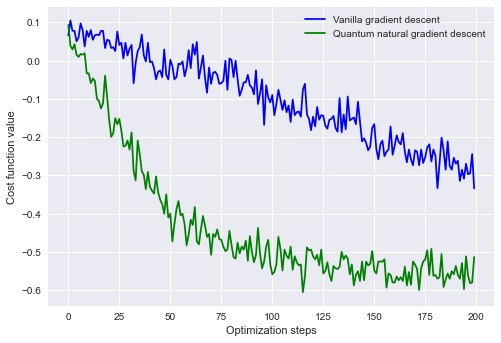

In [18]:
steps = 200
init_params = np.array([0.432, -0.123, 0.543, 0.233])

gd_cost = []
opt = qml.GradientDescentOptimizer(0.01)

print("Starting GD Optimizer run...")
theta = init_params
for _ in range(steps):
    theta = opt.step(circuit, theta)
    gd_cost.append(circuit(theta))
print("Done.")
    
qng_cost = []
opt = qml.QNGOptimizer(0.01, diag_approx=True)

print("Starting builtin QNG Optimizer run...")
theta = init_params
for _ in range(steps):
    theta = opt.step(circuit, theta)
    qng_cost.append(circuit(theta))
print("Done.")
    
from matplotlib import pyplot as plt

plt.style.use("seaborn")
plt.plot(gd_cost, "b", label="Vanilla gradient descent")
plt.plot(qng_cost, "g", label="Quantum natural gradient descent")

plt.ylabel("Cost function value")
plt.xlabel("Optimization steps")
plt.legend()
plt.show()